In [1]:
NAME = 'base-kinopoisk'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

2024-06-10 23:59:56.783805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import datetime

import mydata as md

data = md.Data('cache')


In [4]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('kinopoisk')

In [8]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    ngrams=3,
    output_sequence_length=sequence_length
)

In [9]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

2024-06-11 00:06:55.755661: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-11 00:06:55.760192: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 83964960 exceeds 10% of free system memory.
2024-06-11 00:07:02.639117: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 83964960 exceeds 10% of free system memory.


In [10]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [11]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [ ]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=False
)

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=None, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=None, kernel_initializer='he_normal')
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

In [16]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")}"

epochs = 20
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.6237 - f1_score: 0.6085 - loss: 0.8018 - val_accuracy: 0.6467 - val_f1_score: 0.6351 - val_loss: 0.7662
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.6287 - f1_score: 0.6213 - loss: 0.7962 - val_accuracy: 0.6487 - val_f1_score: 0.6364 - val_loss: 0.7631
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.6421 - f1_score: 0.6312 - loss: 0.7853 - val_accuracy: 0.6520 - val_f1_score: 0.6383 - val_loss: 0.7594
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.6495 - f1_score: 0.6400 - loss: 0.7597 - val_accuracy: 0.6467 - val_f1_score: 0.6358 - val_loss: 0.7568
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.6470 - f1_score: 0.6371 - loss: 0.7702 - val_accuracy: 0.6420 - val_f1_score: 0.6272 - val_loss: 0.7472
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.6625 - f1_score: 0.6546 - loss: 0.7351 - val_accuracy: 0.6413 - val_f1_s

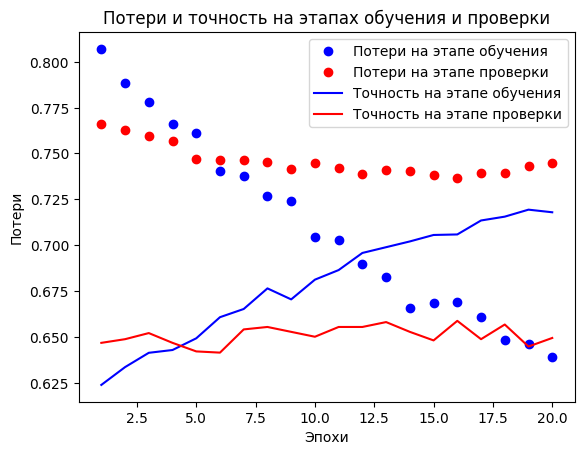

In [17]:
data.plot(history)

In [19]:
model.load_weights(checkpoint_filepath)

In [20]:
model.evaluate(test_ds_batch)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6352 - f1_score: 0.6358 - loss: 0.7801


[0.7743784189224243, 0.6380000114440918, 0.6384186148643494]

In [23]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │     1,284,355 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,355 (4.90 MB)

 Trainable params: 1,284,355 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
raw_tab_train_ds, raw_tab_valid_ds, raw_tab_test_ds = data.load('tabiturient')

Проверяем на данных tabiturient

In [26]:
tab_train_ds = data.vectorize(raw_tab_train_ds, vectorize_layer)
tab_valid_ds = data.vectorize(raw_tab_valid_ds, vectorize_layer)
tab_test_ds = data.vectorize(raw_tab_test_ds, vectorize_layer)

In [27]:
model.evaluate(
    tab_test_ds.batch(16)
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4481 - f1_score: 0.3731 - loss: 1.1717


[1.1453896760940552, 0.46388888359069824, 0.39204415678977966]

In [28]:
model.save(f'models/model-{NAME}.keras')

In [29]:
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

In [30]:
checkpoint_filepath = f"models/checkpoint-{NAME}-fine.weights.h5"

log_dir = f"logs/fit-{NAME}-fine/{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}"

epochs = 10
history = model.fit(
    tab_train_ds.batch(16),
    validation_data=tab_valid_ds.batch(16),
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        # tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4274 - f1_score: 0.3905 - loss: 1.3002 - val_accuracy: 0.4401 - val_f1_score: 0.3673 - val_loss: 1.0943
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4598 - f1_score: 0.4141 - loss: 1.2242 - val_accuracy: 0.4485 - val_f1_score: 0.3788 - val_loss: 1.0839
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4277 - f1_score: 0.3929 - loss: 1.2680 - val_accuracy: 0.4624 - val_f1_score: 0.3903 - val_loss: 1.0743
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4528 - f1_score: 0.4252 - loss: 1.2322 - val_accuracy: 0.4624 - val_f1_score: 0.3900 - val_loss: 1.0654
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4525 - f1_score: 0.4151 - loss: 1.2080 - val_accuracy: 0.4652 - val_f1_score: 0.3901 - val_loss: 1.0569
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4552 - f1_score: 0.4264 - loss: 1.2439 - val_accuracy: 0.4763 - val_f1_score: 

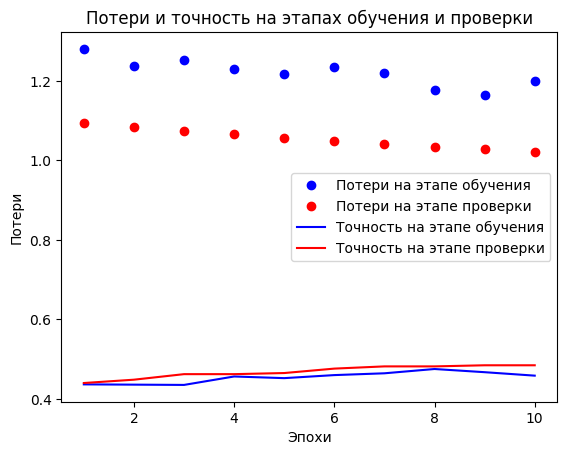

In [31]:
data.plot(history)

In [32]:
model.load_weights(checkpoint_filepath)

In [33]:
model.evaluate(
    tab_test_ds.batch(16)
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4756 - f1_score: 0.4049 - loss: 1.0898


[1.0701602697372437, 0.49444442987442017, 0.4202911853790283]